In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import os
sys.path.append(os.path.abspath('./'))
from mds.mds import mds
from mds.visualizationtools import add_axis_cube, compress_to_sphere

# Plots:

In [53]:
def plot_interpolation(x, y, z, point_idxs, cmap='viridis'):
    """
    Plots a 3D scatter plot of points, color-coded by group index with a smooth color progression.
    Additionally, interpolated geodesic lines are drawn, following the original sampling order, with varying line width to enhance depth perception.

    Parameters:
    - x (array-like): x-coordinates of points.
    - y (array-like): y-coordinates of points.
    - z (array-like): z-coordinates of points.
    - point_idxs (array-like): Group index for each point (used for color coding).
    - cmap (str): Colormap to use for the groups (default: 'viridis' for smooth progression).
    """
    x, y, z, point_idxs = map(np.array, (x, y, z, point_idxs))  
    colormap = cm.get_cmap(cmap)
    unique_idxs = np.unique(point_idxs)
    norm = plt.Normalize(vmin=min(unique_idxs), vmax=max(unique_idxs))
    colors = colormap(norm(point_idxs))  
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
    
    #ax.scatter(x, y, z, c=colors, marker='o', s=20) 
    
    for group in unique_idxs:
        mask = point_idxs == group
        x_group, y_group, z_group = x[mask], y[mask], z[mask]
        
        # Maintain original order (as sampled from geodesic_sample_points)
        if len(x_group) > 1:
            t = np.arange(len(x_group))  
            t_interp = np.linspace(t[0], t[-1], 200)
            x_interp = np.interp(t_interp, t, x_group)
            y_interp = np.interp(t_interp, t, y_group)
            z_interp = np.interp(t_interp, t, z_group)
            
            depth_factor = np.mean(z_group)
            line_width = 1 + (depth_factor - np.min(z)) / (np.max(z) - np.min(z)) * 3  
            
            ax.plot(x_interp, y_interp, z_interp, color=colormap(norm(group)), linewidth=line_width)

    ax.set_title("Fibers of S^3")
    ax.set_axis_off()
    #add_axis_cube(ax, 2)
    
    plt.show()

def plot_interpolation_sphere(x, y, z, point_idxs, cmap='turbo'):
    """
    Plots a 3D scatter plot of points, color-coded by group index with a smooth color progression.
    Additionally, interpolated geodesic lines are drawn, following the original sampling order, 
    with varying line width to enhance depth perception. A reference sphere with minimal distraction 
    is also drawn to indicate the structure of S^2.

    Parameters:
    - x (array-like): x-coordinates of points.
    - y (array-like): y-coordinates of points.
    - z (array-like): z-coordinates of points.
    - point_idxs (array-like): Group index for each point (used for color coding).
    - cmap (str): Colormap to use for the groups (default: 'turbo' for high contrast).
    """
    x, y, z, point_idxs = map(np.array, (x, y, z, point_idxs))  
    colormap = cm.get_cmap(cmap)
    unique_idxs = np.unique(point_idxs)
    norm = plt.Normalize(vmin=min(unique_idxs), vmax=max(unique_idxs))
    colors = colormap(norm(point_idxs))  
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))

    u = np.linspace(0, np.pi, 200)   
    v = np.linspace(0, 2 * np.pi, 200)  
    u, v = np.meshgrid(u, v)
    sphere_x = np.sin(u) * np.cos(v)
    sphere_y = np.sin(u) * np.sin(v)
    sphere_z = np.cos(u)

    ax.plot_surface(sphere_x, sphere_y, sphere_z, color='lightgray', alpha=0.15, 
                    edgecolor='none', linewidth=0, antialiased=True)

    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.3, alpha=0.6)

    for group in unique_idxs:
        mask = point_idxs == group
        x_group, y_group, z_group = x[mask], y[mask], z[mask]
        
        if len(x_group) > 1:
            t = np.arange(len(x_group))  
            t_interp = np.linspace(t[0], t[-1], 300) 
            x_interp = np.interp(t_interp, t, x_group)
            y_interp = np.interp(t_interp, t, y_group)
            z_interp = np.interp(t_interp, t, z_group)
            
            depth_factor = np.mean(z_group)
            line_width = 1.5 + (depth_factor - np.min(z)) / (np.max(z) - np.min(z)) * 3  

            ax.plot(x_interp, y_interp, z_interp, color=colormap(norm(group)), linewidth=line_width, alpha=0.9)

    ax.set_title("Fibers of $S^3$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    ax.view_init(elev=20, azim=30)  

    plt.show()

In [52]:
def spherical_to_cartesian(spherical_points):
    """Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z)."""
    theta, phi = spherical_points[:, 0], spherical_points[:, 1]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.column_stack((x, y, z))

def plot_sampledpoints(points, pts_index, cmap='viridis'):
    """
    Plots points in 3D space with color mapping based on indices and a high-quality shaded sphere.

    Parameters:
    points (np.ndarray): Array of shape (n, 2) in spherical coordinates (theta, phi).
    pts_index (np.ndarray): Indices used for color mapping.
    cmap (str): Colormap name.
    """
    pts = spherical_to_cartesian(points)  
    point_idxs = np.array(pts_index)

    colormap = cm.get_cmap(cmap)
    norm = plt.Normalize(vmin=point_idxs.min(), vmax=point_idxs.max())
    colors = colormap(norm(point_idxs))  

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1]) 
    #theta
    u = np.linspace(0, np.pi, 100)  
    #phi
    v = np.linspace(0, 2 * np.pi, 100)
    u, v = np.meshgrid(u, v)
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)

    ax.plot_surface(x, y, z, color='lightgray', edgecolor='none', 
                    alpha=0.4, cmap='gray', linewidth=0, antialiased=True)

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors, marker='o', 
               s=30, edgecolor='black', linewidth=0.5, zorder=10)  

    ax.set_title("Sampled Points on $S^2$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    ax.view_init(elev=20, azim=30)  

    plt.show()

def plot_sampledpoints2(points, pts_index, cmap='turbo'):
    """
    Plots points in 3D space with color mapping based on indices.

    Parameters:
    points (np.ndarray): Array of shape (n, 2) in spherical coordinates (theta, phi).
    pts_index (np.ndarray): Indices used for color mapping.
    cmap (str): Colormap name.
    """
    pts = spherical_to_cartesian(points)  
    point_idxs = np.array(pts_index)

    colormap = cm.get_cmap(cmap)
    norm = plt.Normalize(vmin=point_idxs.min(), vmax=point_idxs.max())
    colors = colormap(norm(point_idxs))  

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1]) 

    u = np.linspace(0, np.pi, 100)
    v = np.linspace(0, 2 * np.pi, 100) 
    u, v = np.meshgrid(u, v)
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)

    ax.plot_surface(x, y, z, color='lightgray', edgecolor='none', 
                    alpha=0.5, cmap='gray', linewidth=0, antialiased=True)

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors, marker='o', 
                s=50, edgecolor='black', linewidth=0.6, zorder=10, depthshade=False)  

    ax.set_title("Sampled Points on $S^2$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    ax.view_init(elev=20, azim=30)  

    plt.show()



**IDEA:**
<br>$(S^3,S^2,\pi,S^1)$ is a fiber bundle, where $\pi : S^3 \to S^2$ being the Hopf
fibration, and for every $p\in S^2, \pi^{-1}(p)=S^1$. The idea is to visualize the fibers corresponding to some points in $S^2$.

- Step 1:
<br>Sample $n$ points in $S^2$ in local coordinates.

In [6]:
def localcoordsampling_2sphere(n):
    """
    Generate approximately equidistant points on the 2-sphere and return them in
    spherical coordinates (local parametrization).

    Parameters:
    n (int): Number of points to sample.

    Returns:
    np.ndarray: Array of shape (n, 2), where each row is (theta, phi).
    """
    phi = (1 + np.sqrt(5)) / 2

    points = np.zeros((n, 2))

    for k in range(n):
        theta = np.arccos(1 - 2 * (k + 0.5) / n)  # Latitude (theta), range [0, π]
        phi_k = 2 * np.pi * (k / phi**2)          # Longitude (phi), range [0, 2π]

        points[k, 0] = theta
        points[k, 1] = phi_k

    return points

- Step 2:
<br>Compute the corresponding fiber of each point, through the inverse of the Hopf fibration.
$$
p=(\theta,\phi)\in S^2,\quad H^{-1}((\theta,\phi))=\{\left(\cos(\frac{\theta}{2}) e^{i\psi}, \sin(\frac{\theta}{2} e^{i(\phi + \psi)})\right), \psi\in[0,2\pi) \}
$$
We can already return $n_{points}$ of the fiber for each point, always the same amount for each fiber,
and in the end have something of this form:
$$
F = \begin{pmatrix}
f_{11} & ... & f_{1n} \\
\vdots & & \vdots\\
f_{d1} & ... & f_{dn}
\end{pmatrix},
$$
where $n$ is the number of points sampled in each fiber and $d$ is the number of
points sampled in $S^2$.

In [7]:
def hopf_fibration_inverse(points, num_samples):
    """
    Computes the inverse Hopf fibration for multiple points on S^2.
    
    Parameters:
        points (ndarray): Array of shape (N, 2) containing spherical coordinates (theta, phi) of points on S^2.
                          theta: Polar angle (0 <= theta <= pi)
                          phi: Azimuthal angle (0 <= phi < 2pi)
        num_samples (int): Number of points to sample from each fiber.
    
    Returns:
        list of tuples: Each tuple contains:
            - fiber_index (int): The index of the point on S^2 the fiber belongs to.
            - sampled_fiber (ndarray): Array of shape (num_samples, 4) containing the sampled fiber points in S^3.
    """
    fibers = []
    
    for index, (theta, phi) in enumerate(points):
        
        psi_values = np.linspace(0, 2 * np.pi, num_samples, endpoint=False)
        
        half_theta = theta / 2
        z1 = np.cos(half_theta) * np.exp(1j * psi_values)  
        z2 = np.sin(half_theta) * np.exp(1j * (phi + psi_values))  
        
        x1, y1 = np.real(z1), np.imag(z1)
        x2, y2 = np.real(z2), np.imag(z2)
        
        # Stack into a (num_samples, 4) array
        sampled_fiber = np.column_stack([x1, y1, x2, y2])

        fibers.append((index, sampled_fiber))
    
    return fibers

- Step 3: Already automatized in mds function:
<br> Compute distance matrix (symmetric matrix of size $d\cdot n\times d\cdot n$)

$$
D = \begin{pmatrix}
d(f_{11},f_{11}) & ... & d(f_{11},f{1n}) & ... & d(f_{11}, f_{d1}) & ... & d(f_{11},f_{dn}) \\
\vdots & & & & & & \vdots\\
d(f_{dn},f_{11}) & ... & d(f_{dn},f{1n}) & ... & d(f_{dn}, f_{d1}) & ... & d(f_{dn},f_{dn}) 
\end{pmatrix}
$$
<br>Convert distance matrix to B matrix needed as input for mds. Project fibers into
R^3 using mds.

- Step 4: Visualization
<br>Plot points from each fiber the same colour and interpolate.

**EXAMPLES:**

# 1 sampled point

In [47]:
points_1 = localcoordsampling_2sphere(1)
num_samples = 1000
fiber_index, sampled_fibers = zip(*hopf_fibration_inverse(points_1, num_samples))
sampled_fibers = np.vstack(sampled_fibers)  # Shape (30, 4)
fiber_index1 = np.repeat(fiber_index, num_samples)  # Shape (30,)

In [48]:
x1, y1, z1 = mds(sampled_fibers, 3)

There are 1000 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 996 (99.60%)


C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1984591692.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


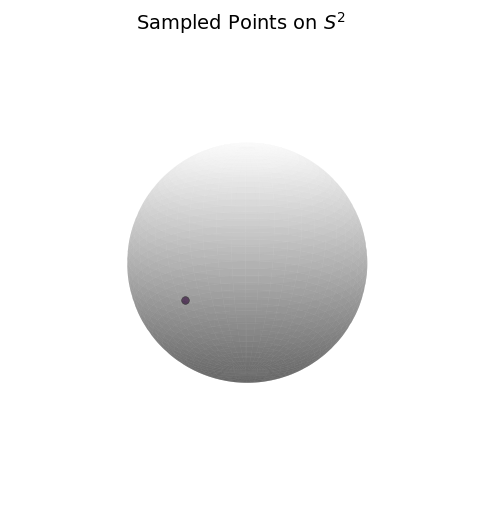

In [54]:
plot_sampledpoints(points_1, [0])

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\2358713903.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


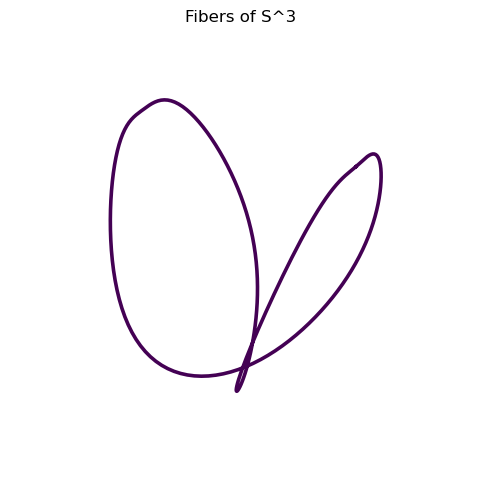

In [55]:
plot_interpolation(x1, y1, z1, fiber_index1)

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1429587911.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


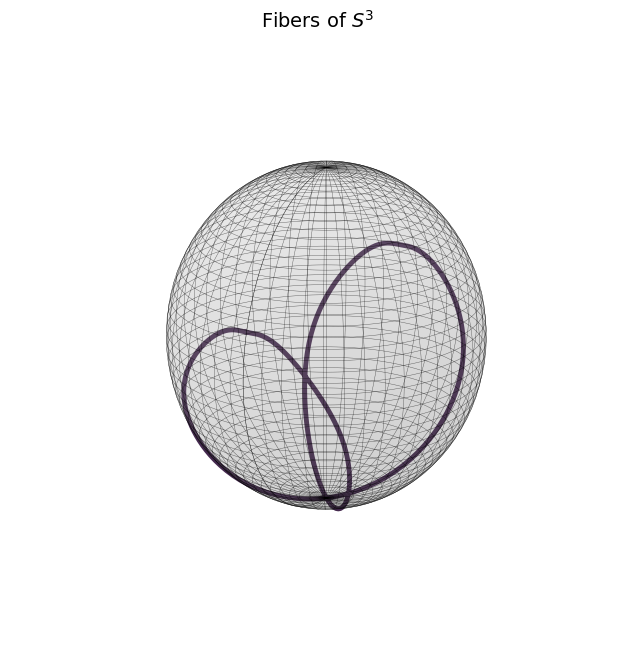

In [51]:
x1c, y1c, z1c = compress_to_sphere(3, x1, y1, z1)
plot_interpolation_sphere(x1c, y1c, z1c, fiber_index1)

# 3 sampled points

In [18]:
points_3 = localcoordsampling_2sphere(3)
num_samples = 1000
fiber_index, sampled_fibers = zip(*hopf_fibration_inverse(points_3, num_samples))
sampled_fibers = np.vstack(sampled_fibers)  # Shape (30, 4)
fiber_index = np.repeat(fiber_index, num_samples)  # Shape (30,)



In [19]:
x, y, z = mds(sampled_fibers, 3)

There are 3000 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 2953 (98.43%)


C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1694648728.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


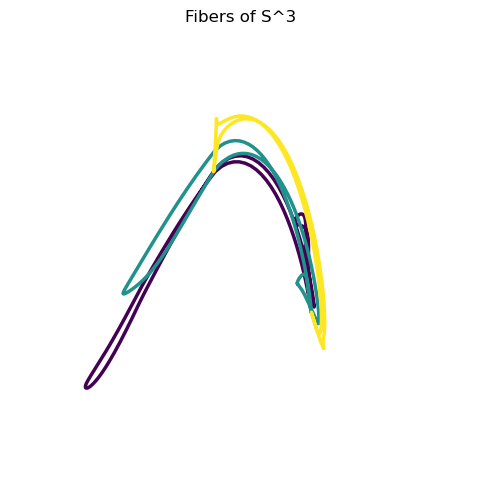

In [20]:
plot_interpolation(x,y,z,fiber_index)

In [21]:
x3c, y3c, z3c = compress_to_sphere(3, x,y,z)

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1429587911.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


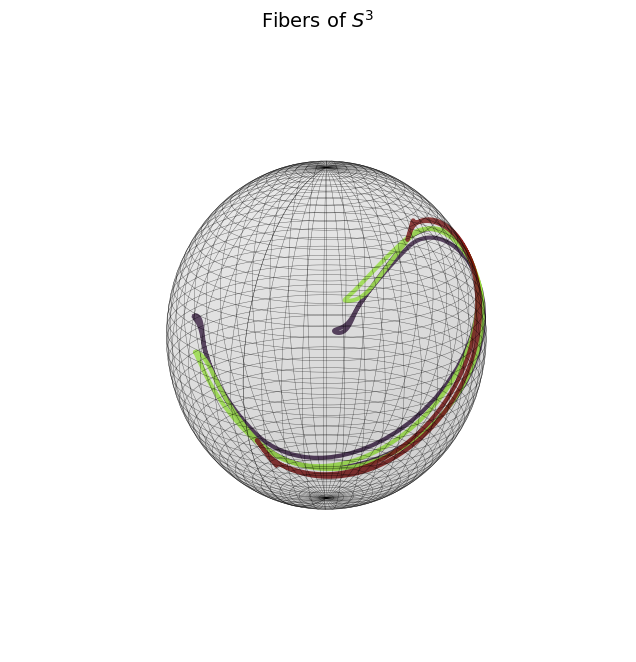

In [45]:
plot_interpolation_sphere(x3c, y3c, z3c, fiber_index)

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\2902032784.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


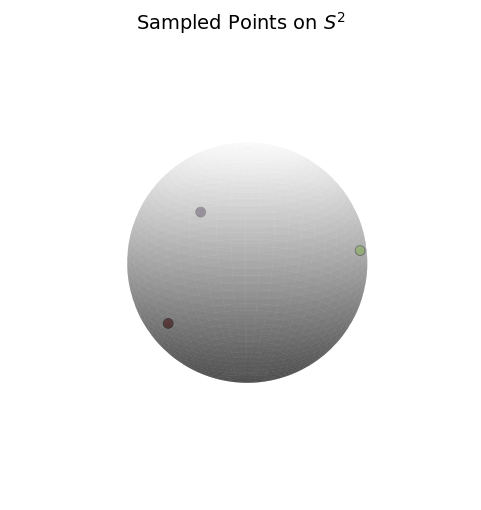

In [37]:
plot_sampledpoints2(points_3, [0,1,2])

# 6 sampled points

In [8]:
points_6 = localcoordsampling_2sphere(6)
num_samples = 1000
fiber_index, sampled_fibers = zip(*hopf_fibration_inverse(points_6, num_samples))
sampled_fibers6 = np.vstack(sampled_fibers)  # Shape (30, 4)
fiber_index6 = np.repeat(fiber_index, num_samples)  # Shape (30,)

In [9]:
x6, y6, z6 = mds(sampled_fibers6, 3)

There are 6000 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 5877 (97.95%)


C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1694648728.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


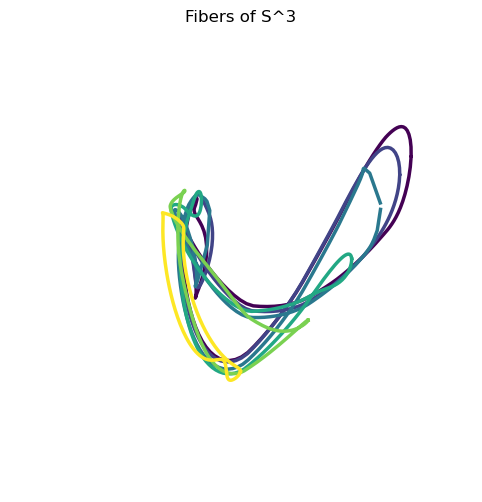

In [10]:
plot_interpolation(x6, y6, z6, fiber_index6)

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\2902032784.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


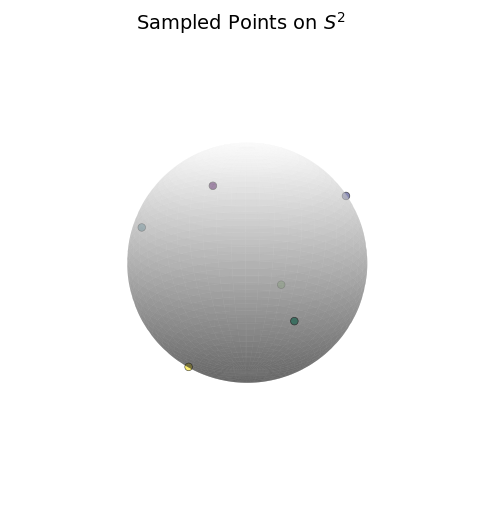

In [38]:
plot_sampledpoints(points_6,[0,1,2,3,4,5])

C:\Users\laura\AppData\Local\Temp\ipykernel_7788\1429587911.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


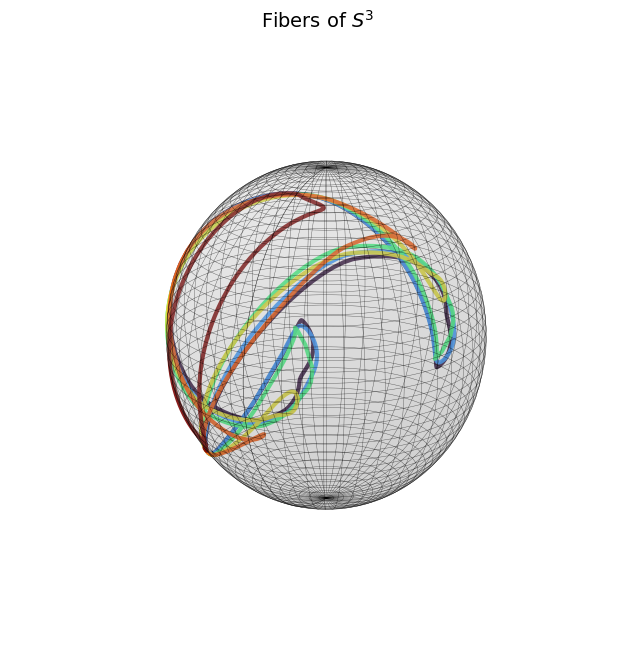

In [46]:
x6c, y6c, z6c = compress_to_sphere(3, x6, y6, z6)
plot_interpolation_sphere(x6c, y6c, z6c, fiber_index6)